In [1]:
%matplotlib inline

import altair as alt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nivapy3 as nivapy
import utils

plt.style.use("ggplot")

# Ion balances for 1000 Lakes survey

See e-mail from Atle received 18.02.2020 at 09.32 for details.

## 1. Read data

In [2]:
# Read data from main visualisation
df = pd.read_csv("../1000_lakes_lw_am.csv")
df = df.query('status in ("Entered", "Authorised", "Modified")')
df["par_unit"] = df["parameter"] + "-" + df["units"]
df.head()

,sample_id,station_id,station_name,station_type,sample_date,parameter,status,loq,value_lw,units,value_am,par_unit
0,104322,26420.0,Simonstadvatnet,Innsjø,2019-10-29,Bly,Authorised,"0,01",0.68,UG_P_L,0.660,Bly-UG_P_L
1,104322,26420.0,Simonstadvatnet,Innsjø,2019-10-29,Aluminium,Authorised,1,390.00,UG_P_L,24.000,Aluminium-UG_P_L
2,104322,26420.0,Simonstadvatnet,Innsjø,2019-10-29,Arsen,Authorised,"0,02",0.33,UG_P_L,0.357,Arsen-UG_P_L
3,104322,26420.0,Simonstadvatnet,Innsjø,2019-10-29,Kobber,Authorised,"0,05",1.10,UG_P_L,1.000,Kobber-UG_P_L
4,104322,26420.0,Simonstadvatnet,Innsjø,2019-10-29,Krom,Authorised,"0,05",0.46,UG_P_L,0.400,Krom-UG_P_L


**Note:** The code below **fills missing data with zero** before performing the ion balance calculations. If this is not desirable, set `fillna=False` in the calls to `utils.ion_balance()`.

## 2. Perform ion balance

In [3]:
# Split into batches based on Ca concentrations in Labware
ca_levels = [
    "0.0 <= Ca_mgpl < 0.5",
    "0.5 <= Ca_mgpl < 1.0",
    "1.0 <= Ca_mgpl < 2.0",
    "Ca_mgpl >= 2",
]

ca_labels = {
    "0.0 <= Ca_mgpl < 0.5": "0.0 ≤ Ca (mg/l) < 0.5",
    "0.5 <= Ca_mgpl < 1.0": "0.5 ≤ Ca (mg/l) < 1.0",
    "1.0 <= Ca_mgpl < 2.0": "1.0 ≤ Ca (mg/l) < 2.0",
    "Ca_mgpl >= 2": "Ca (mg/l) ≥ 2.0",
}

# Loop over Ca "levels"
res_dict = {}
for ca_level in ca_levels:
    # Get Labware data
    lw_df = df[["station_id", "station_name", "sample_date", "par_unit", "value_lw"]]
    lw_df = lw_df.groupby(
        ["station_id", "station_name", "sample_date", "par_unit"]
    ).mean()
    lw_df = lw_df.unstack("par_unit")
    lw_df.columns = lw_df.columns.get_level_values(1)
    lw_df.columns.name = None
    lw_df.reset_index(inplace=True)

    # Filter based on Ca value
    lw_df["Ca_mgpl"] = lw_df["Kalsium-MG_P_L"]
    lw_df = lw_df.query(ca_level)
    del lw_df["Ca_mgpl"]

    # Get AM data
    am_df = df[["station_id", "station_name", "sample_date", "par_unit", "value_am"]]
    am_df = am_df.groupby(
        ["station_id", "station_name", "sample_date", "par_unit"]
    ).mean()
    am_df = am_df.unstack("par_unit")
    am_df.columns = am_df.columns.get_level_values(1)
    am_df.columns.name = None
    am_df.reset_index(inplace=True)

    # Ion balance
    lw_df = utils.ion_balance(lw_df, fillna=True)
    am_df = utils.ion_balance(am_df, fillna=True)

    # Merge
    res_df = pd.merge(
        lw_df,
        am_df,
        on=["station_id", "station_name", "sample_date"],
        how="left",
        suffixes=["_lw", "_am"],
    )

    # Filter columns
    res_df = res_df[
        [
            "station_id",
            "station_name",
            "sample_date",
            "ion_diff_pct_lw",
            "ion_diff_pct_am",
            "kond_diff_pct_lw",
            "kond_diff_pct_am",
            "kond_minus_H&SO4_lw",
            "kond_minus_H&SO4_am",
        ]
    ]
    res_df.dropna(inplace=True)

    # Store output
    res_dict[ca_level] = res_df

## 3. Charts

### 3.1. Ion difference in percent

In [4]:
chart_dict = {}
for idx, ca_level in enumerate(ca_levels):
    data = res_dict[ca_level]

    base = alt.Chart(data, height=400, width=400)

    x_domain = alt.selection_interval(bind="scales", encodings=["x"])
    y_domain = alt.selection_interval(bind="scales", encodings=["y"])

    area_args = {"opacity": 0.3, "interpolate": "step"}

    points = (
        base.mark_point()
        .encode(
            x=alt.X(
                "ion_diff_pct_am:Q", title="Ion difference (Aquamonitor, 1995) [%]"
            ),
            y=alt.Y("ion_diff_pct_lw:Q", title="Ion difference (Labware, 2019) [%]"),
            tooltip=[
                "station_id:N",
                "station_name:N",
                "sample_date:T",
                "ion_diff_pct_lw:Q",
                "ion_diff_pct_am:Q",
            ],
        )
        .properties(title=ca_level)
        .add_selection(x_domain)
        .add_selection(y_domain)
    )

    # 1:1 line
    line = base.mark_line().encode(
        x=alt.X("ion_diff_pct_am:Q", title=""), y=alt.Y("ion_diff_pct_am:Q", title=""),
    )

    top_hist = (
        base.mark_area(**area_args)
        .encode(
            alt.X("ion_diff_pct_am:Q", bin=alt.Bin(maxbins=20), stack=None, title=""),
            alt.Y("count()", stack=None, title=""),
        )
        .properties(height=60)
        .add_selection(x_domain)
    )

    right_hist = (
        base.mark_area(**area_args)
        .encode(
            alt.Y("ion_diff_pct_lw:Q", bin=alt.Bin(maxbins=20), stack=None, title="",),
            alt.X("count()", stack=None, title=""),
        )
        .properties(width=60)
        .add_selection(y_domain)
    )

    chart = top_hist & ((points + line) | right_hist)
    chart_dict[idx] = chart

chart = (chart_dict[0] | chart_dict[1]) & (chart_dict[2] | chart_dict[3])
chart.save("../pages/ion_difference_pct.html")
chart

alt.VConcatChart(...)

### 3.2. Conductivity difference in percent

In [5]:
chart_dict = {}
for idx, ca_level in enumerate(ca_levels):
    data = res_dict[ca_level]

    base = alt.Chart(data, height=400, width=400)

    x_domain = alt.selection_interval(bind="scales", encodings=["x"])
    y_domain = alt.selection_interval(bind="scales", encodings=["y"])

    area_args = {"opacity": 0.3, "interpolate": "step"}

    points = (
        base.mark_point()
        .encode(
            x=alt.X(
                "kond_diff_pct_am:Q",
                title="Conductivity difference (Aquamonitor, 1995) [%]",
            ),
            y=alt.Y(
                "kond_diff_pct_lw:Q",
                title="Conductivity difference (Labware, 2019) [%]",
            ),
            tooltip=[
                "station_id:N",
                "station_name:N",
                "sample_date:T",
                "kond_diff_pct_lw:Q",
                "kond_diff_pct_am:Q",
            ],
        )
        .properties(title=ca_level)
        .add_selection(x_domain)
        .add_selection(y_domain)
    )

    # 1:1 line
    line = base.mark_line().encode(
        x=alt.X("kond_diff_pct_am:Q", title=""),
        y=alt.Y("kond_diff_pct_am:Q", title=""),
    )

    top_hist = (
        base.mark_area(**area_args)
        .encode(
            alt.X("kond_diff_pct_am:Q", bin=alt.Bin(maxbins=20), stack=None, title=""),
            alt.Y("count()", stack=None, title=""),
        )
        .properties(height=60)
        .add_selection(x_domain)
    )

    right_hist = (
        base.mark_area(**area_args)
        .encode(
            alt.Y("kond_diff_pct_lw:Q", bin=alt.Bin(maxbins=20), stack=None, title="",),
            alt.X("count()", stack=None, title=""),
        )
        .properties(width=60)
        .add_selection(y_domain)
    )

    chart = top_hist & ((points + line) | right_hist)
    chart_dict[idx] = chart

chart = (chart_dict[0] | chart_dict[1]) & (chart_dict[2] | chart_dict[3])
chart.save("../pages/cond_difference_pct.html")
chart

alt.VConcatChart(...)

### 3.3. Corrected conductivity

Calculated as

$$K_{corr} = K_{raw} - 0.035H^+ - 0.008SO_4$$

where $K_{corr}$ is in mS/m and $H^+$ & $SO_4$ are in ueq/l.

In [6]:
chart_dict = {}
for idx, ca_level in enumerate(ca_levels):
    data = res_dict[ca_level]

    base = alt.Chart(data, height=400, width=400)

    x_domain = alt.selection_interval(bind="scales", encodings=["x"])
    y_domain = alt.selection_interval(bind="scales", encodings=["y"])

    area_args = {"opacity": 0.3, "interpolate": "step"}

    points = (
        base.mark_point()
        .encode(
            x=alt.X(
                "kond_minus_H&SO4_am:Q", title="Korrigert konduktivitet i 1995 (mS/m)"
            ),
            y=alt.Y(
                "kond_minus_H&SO4_lw:Q", title="Korrigert konduktivitet i 2019 (mS/m)"
            ),
            tooltip=[
                "station_id:N",
                "station_name:N",
                "sample_date:T",
                "kond_minus_H&SO4_lw:Q",
                "kond_minus_H&SO4_am:Q",
            ],
        )
        .properties(title=ca_labels[ca_level])
        .add_selection(x_domain)
        .add_selection(y_domain)
    )

    # 1:1 line
    line = base.mark_line().encode(
        x=alt.X("kond_minus_H&SO4_am:Q", title=""),
        y=alt.Y("kond_minus_H&SO4_am:Q", title=""),
    )

    top_hist = (
        base.mark_area(**area_args)
        .encode(
            alt.X(
                "kond_minus_H&SO4_am:Q", bin=alt.Bin(maxbins=20), stack=None, title=""
            ),
            alt.Y("count()", stack=None, title=""),
        )
        .properties(height=60)
        .add_selection(x_domain)
    )

    right_hist = (
        base.mark_area(**area_args)
        .encode(
            alt.Y(
                "kond_minus_H&SO4_lw:Q", bin=alt.Bin(maxbins=20), stack=None, title="",
            ),
            alt.X("count()", stack=None, title=""),
        )
        .properties(width=60)
        .add_selection(y_domain)
    )

    chart = top_hist & ((points + line) | right_hist)
    chart_dict[idx] = chart

chart = (chart_dict[0] | chart_dict[1]) & (chart_dict[2] | chart_dict[3])
chart.save("../pages/corrected_cond.html")
chart

alt.VConcatChart(...)

The code below is absolutely horrible. It recreates the plot above with finer control over styling etc. This has allowed me to quickly make the changes requested by Øyvind (see e-mail received 31.08.2020). If you ever need to use this... sorry.

In [7]:
def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y, s=40, facecolors="none", edgecolors="steelblue", lw=1)

    # now determine nice limits by hand:
    binwidth = 0.25
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax / binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    xcounts = ax_histx.hist(x, bins=bins, alpha=0.5, color="steelblue")[0]
    ycounts = ax_histy.hist(
        y, bins=bins, orientation="horizontal", alpha=0.5, color="steelblue"
    )[0]

    return max(xcounts.max(), ycounts.max())

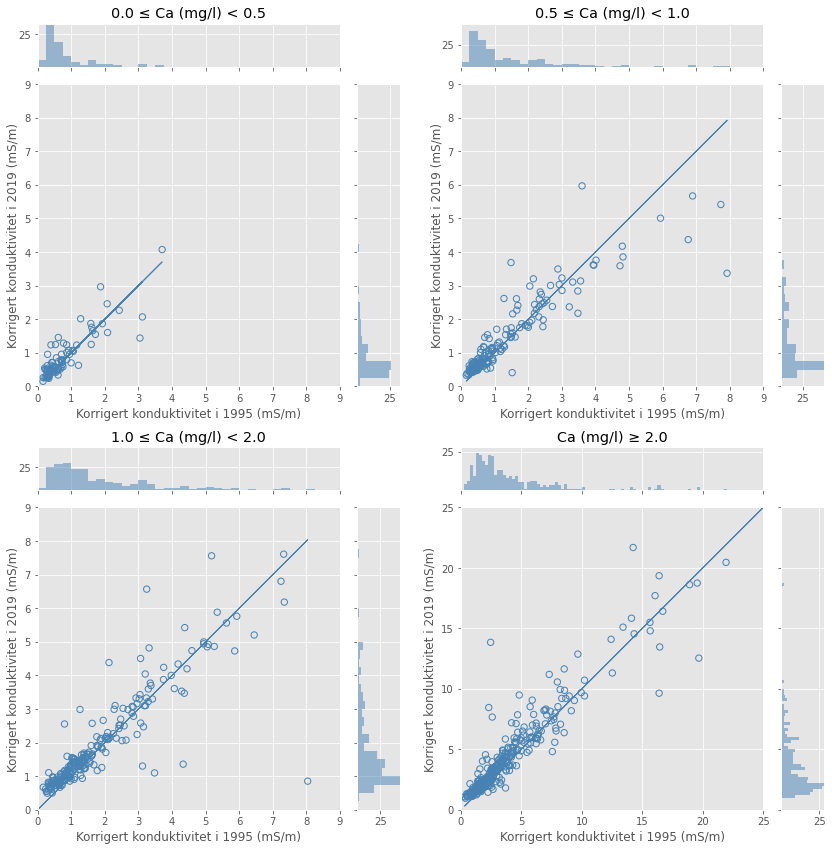

In [8]:
# Axis dimensions
sc = 0.35  # Scatterplots
spc = 0.05  # Spacing at edges and between
hi = 0.05  # Histogram height
pad = 0.04  # Additional spacing between subplots
mar = 0.02  # Spacing between scatter plots and histograms

# Start with a square Figure
fig = plt.figure(figsize=(12, 12))

# Top left
p1 = [spc, spc + sc + hi + spc + pad, sc, sc]
hx1 = [spc, spc + sc + hi + spc + sc + pad + mar, sc, hi]
hy1 = [spc + sc + mar, spc + sc + hi + spc + pad, hi, sc]

ax_p1 = fig.add_axes(p1)
ax_hx1 = fig.add_axes(hx1, sharex=ax_p1)
ax_hy1 = fig.add_axes(hy1, sharey=ax_p1)

# Top right
p2 = [spc + sc + hi + spc + pad, spc + sc + hi + spc + pad, sc, sc]
hx2 = [spc + sc + hi + spc + pad, spc + sc + hi + spc + sc + pad + mar, sc, hi]
hy2 = [spc + sc + hi + spc + sc + pad + mar, spc + sc + hi + spc + pad, hi, sc]

ax_p2 = fig.add_axes(p2)
ax_hx2 = fig.add_axes(hx2, sharex=ax_p2)
ax_hy2 = fig.add_axes(hy2, sharey=ax_p2)

# Bottom left
p3 = [spc, spc, sc, sc]
hx3 = [spc, spc + sc + mar, sc, hi]
hy3 = [spc + sc + mar, spc, hi, sc]

ax_p3 = fig.add_axes(p3)
ax_hx3 = fig.add_axes(hx3, sharex=ax_p3)
ax_hy3 = fig.add_axes(hy3, sharey=ax_p3)

# Bottom right
p4 = [spc + sc + hi + spc + pad, spc, sc, sc]
hx4 = [spc + sc + hi + spc + pad, spc + sc + mar, sc, hi]
hy4 = [spc + sc + hi + spc + sc + pad + mar, spc, hi, sc]

ax_p4 = fig.add_axes(p4)
ax_hx4 = fig.add_axes(hx4, sharex=ax_p4)
ax_hy4 = fig.add_axes(hy4, sharey=ax_p4)

# Plot data
data1 = res_dict["0.0 <= Ca_mgpl < 0.5"]
hmax1 = scatter_hist(
    data1["kond_minus_H&SO4_am"], data1["kond_minus_H&SO4_lw"], ax_p1, ax_hx1, ax_hy1
)
ax_p1.plot(
    data1["kond_minus_H&SO4_am"], data1["kond_minus_H&SO4_am"], color="steelblue", lw=1
)

data2 = res_dict["0.5 <= Ca_mgpl < 1.0"]
hmax2 = scatter_hist(
    data2["kond_minus_H&SO4_am"], data2["kond_minus_H&SO4_lw"], ax_p2, ax_hx2, ax_hy2
)
ax_p2.plot(
    data2["kond_minus_H&SO4_am"], data2["kond_minus_H&SO4_am"], color="steelblue", lw=1
)

data3 = res_dict["1.0 <= Ca_mgpl < 2.0"]
hmax3 = scatter_hist(
    data3["kond_minus_H&SO4_am"], data3["kond_minus_H&SO4_lw"], ax_p3, ax_hx3, ax_hy3
)
ax_p3.plot(
    data3["kond_minus_H&SO4_am"], data3["kond_minus_H&SO4_am"], color="steelblue", lw=1
)

data4 = res_dict["Ca_mgpl >= 2"]
hmax4 = scatter_hist(
    data4["kond_minus_H&SO4_am"], data4["kond_minus_H&SO4_lw"], ax_p4, ax_hx4, ax_hy4
)
ax_p4.plot(
    data4["kond_minus_H&SO4_am"], data4["kond_minus_H&SO4_am"], color="steelblue", lw=1
)

# Adjust axis limits
for ax in [ax_p1, ax_p2, ax_p3]:
    ax.set_xlim((0, 9))
    ax.set_ylim((0, 9))
ax_p4.set_xlim((0, 25))
ax_p4.set_ylim((0, 25))

ax_hx1.set_ylim(ymax=hmax1)
ax_hy1.set_xlim(xmax=hmax1)

ax_hx2.set_ylim(ymax=hmax2)
ax_hy2.set_xlim(xmax=hmax2)

ax_hx3.set_ylim(ymax=hmax3)
ax_hy3.set_xlim(xmax=hmax3)

ax_hx4.set_ylim(ymax=hmax4)
ax_hy4.set_xlim(xmax=hmax4)

ax_hx1.set_yticks([25])
ax_hy1.set_xticks([25])

ax_hx2.set_yticks([25])
ax_hy2.set_xticks([25])

ax_hx3.set_yticks([25])
ax_hy3.set_xticks([25])

ax_hx4.set_yticks([25])
ax_hy4.set_xticks([25])

# Add labels
ax_hx1.set_title("0.0 ≤ Ca (mg/l) < 0.5")
ax_hx2.set_title("0.5 ≤ Ca (mg/l) < 1.0")
ax_hx3.set_title("1.0 ≤ Ca (mg/l) < 2.0")
ax_hx4.set_title("Ca (mg/l) ≥ 2.0")

for ax in [ax_p1, ax_p2, ax_p3, ax_p4]:
    ax.set_xlabel("Korrigert konduktivitet i 1995 (mS/m)")
    ax.set_ylabel("Korrigert konduktivitet i 2019 (mS/m)")

plt.savefig("corrected_conductivity.png", dpi=300)